### Simple PINN with physics loss

In [1]:
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Load dataset
file = xr.open_dataset('../dat/RBC_Output.nc')

# Extract variables
b = file['b']
p_dyn = file['p_dyn']
u = file['u']
w = file['w']

z_aac = file['z_aac'].values
z_aaf = file['z_aaf'].values

# Time selection: first 50 steps
time_indices = slice(0, 50)
b = b.isel(time=time_indices)
p_dyn = p_dyn.isel(time=time_indices)
u = u.isel(time=time_indices)
w = w.isel(time=time_indices)

# Step 1: Select top 100 depths (approx top 40%)
# Depths from z=-0.4 to z=0 correspond to approximately top 100 points (confirmed: 256 * 0.4 ≈ 102)
top_100_depths = 100
z_indices_full = np.arange(b.sizes['z_aac'])  # full indices
z_indices_top = z_indices_full[-top_100_depths:]  # last 100 depths (closer to surface)

# Step 2: Downsample to 50 depths by taking even-indexed points
z_indices_50 = z_indices_top[::2]  # take every second depth → 50 points

# Apply this depth selection consistently
b = b.isel(z_aac=z_indices_50)
p_dyn = p_dyn.isel(z_aac=z_indices_50)
u = u.isel(z_aac=z_indices_50)
w = w.isel(z_aaf=z_indices_50)  # w uses z_aaf

# Average over x dimensions
b_avg = b.mean(dim='x_caa')
p_dyn_avg = p_dyn.mean(dim='x_caa')
u_avg = u.mean(dim='x_faa')
w_avg = w.mean(dim='x_caa')

# Extract numpy arrays: shapes (time=50, depth=50)
b_ds = b_avg.values
p_dyn_ds = p_dyn_avg.values
u_ds = u_avg.values
w_ds = w_avg.values

# Time values normalized to [0,1]
time_vals = np.linspace(0, 1, b_ds.shape[0])

# Depth values (physical) — z_aac for selected indices
depth_vals_physical = z_aac[z_indices_50]
depth_vals_normalized = (depth_vals_physical - depth_vals_physical.min()) / (depth_vals_physical.max() - depth_vals_physical.min())

print("Final shapes:", b_ds.shape, p_dyn_ds.shape, u_ds.shape, w_ds.shape)
print("Depths (physical):", depth_vals_physical)


Final shapes: (50, 50) (50, 50) (50, 50) (50, 50)
Depths (physical): [-0.38867188 -0.38085938 -0.37304688 -0.36523438 -0.35742188 -0.34960938
 -0.34179688 -0.33398438 -0.32617188 -0.31835938 -0.31054688 -0.30273438
 -0.29492188 -0.28710938 -0.27929688 -0.27148438 -0.26367188 -0.25585938
 -0.24804688 -0.24023438 -0.23242188 -0.22460938 -0.21679688 -0.20898438
 -0.20117188 -0.19335938 -0.18554688 -0.17773438 -0.16992188 -0.16210938
 -0.15429688 -0.14648438 -0.13867188 -0.13085938 -0.12304688 -0.11523438
 -0.10742188 -0.09960938 -0.09179688 -0.08398438 -0.07617188 -0.06835938
 -0.06054688 -0.05273438 -0.04492188 -0.03710938 -0.02929688 -0.02148438
 -0.01367188 -0.00585938]


C:\Users\deban\AppData\Local\Temp\ipykernel_23936\580628525.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  file = xr.open_dataset('../dat/RBC_Output.nc')


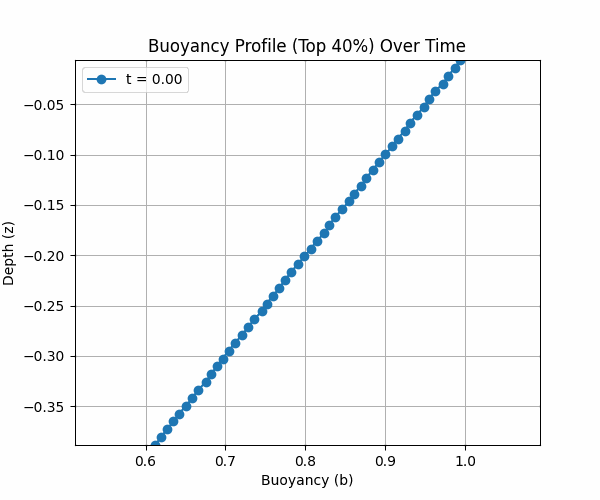

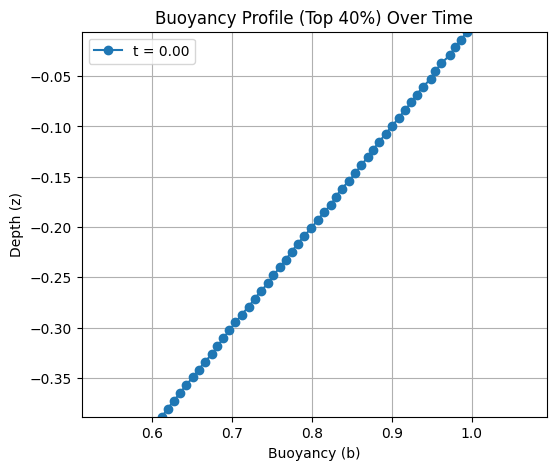

In [3]:
import matplotlib.animation as animation
from IPython.display import Image, display

# Use depth_vals_physical from Block 2 (not generating new depths here)
physical_z = depth_vals_physical
# Optional: normalize for plotting if you want it between 0 and 1
# physical_z = (physical_z - physical_z.min()) / (physical_z.max() - physical_z.min())

fig, ax = plt.subplots(figsize=(6, 5))

def update(frame):
    ax.clear()
    ax.plot(b_ds[frame], physical_z, 'o-', label=f't = {time_vals[frame]:.2f}')
    ax.set_xlim(b_ds.min() - 0.1, b_ds.max() + 0.1)
    ax.set_ylim(physical_z.min(), physical_z.max())
    ax.set_xlabel('Buoyancy (b)')
    ax.set_ylabel('Depth (z)')
    ax.set_title('Buoyancy Profile (Top 40%) Over Time')
    ax.legend()
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(time_vals), blit=False, interval=300)

ani.save('buoyancy_profile_top40.gif', writer='pillow', fps=8)
display(Image(filename='buoyancy_profile_top40.gif'))


In [4]:
# Flattened profiles → Build profile-based inputs for each time step
X_profiles = []
Y_profiles = []

for i in range(b_ds.shape[0]):  # over time (50 time steps)
    t_val = time_vals[i]
    u_profile = u_ds[i]       # shape (50,)
    w_profile = w_ds[i]
    p_dyn_profile = p_dyn_ds[i]
    b_profile = b_ds[i]
    
    # Concatenate profiles into single input vector
    input_vector = np.concatenate([
        [t_val],               # time (scalar)
        u_profile,             # u(z) → length 50
        w_profile,             # w(z) → length 50
        p_dyn_profile          # p_dyn(z) → length 50
        # (Add constants here if needed)
    ])
    
    X_profiles.append(input_vector)
    Y_profiles.append(b_profile)  # Target: b(z), shape (50,)

X_profiles = np.array(X_profiles)    # shape: (50, input_dim)
Y_profiles = np.array(Y_profiles)    # shape: (50, 50)

# Train: t=6 to 35 → indices 6 to 35 (inclusive) → 30 samples
X_train_np = X_profiles[6:36]
Y_train_np = Y_profiles[6:36]

# Test: t=36 onwards → indices 36 to 49 → 14 samples
X_test_np = X_profiles[36:50]
Y_test_np = Y_profiles[36:50]

# Torch conversion
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32).to(device)

X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test_np, dtype=torch.float32).to(device)

print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")


X_train: torch.Size([30, 151]), Y_train: torch.Size([30, 50])
X_test: torch.Size([14, 151]), Y_test: torch.Size([14, 50])


In [5]:
class PINN_Profile(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN_Profile, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
def compute_physics_loss(model, X_batch, z_tensor, kappa):
    X_batch.requires_grad_(True)
    b_pred = model(X_batch)  # shape: (batch_size, 50)
    
    # Compute ∂b/∂t
    b_sum = b_pred.sum(dim=1)
    grads = torch.autograd.grad(b_sum, X_batch, grad_outputs=torch.ones_like(b_sum), create_graph=True)[0]
    db_dt = grads[:, 0].unsqueeze(1)  # time derivative → (batch, 1)

    # Compute ∂b/∂z and ∂²b/∂z² along profile axis
    dz = (z_tensor[1] - z_tensor[0]).item()
    db_dz = (b_pred[:, 2:] - b_pred[:, :-2]) / (2 * dz)  # central difference → (batch, 48)
    d2b_dz2 = (b_pred[:, 2:] - 2 * b_pred[:, 1:-1] + b_pred[:, :-2]) / (dz ** 2)  # (batch, 48)

    # Interpolate w to match the midpoints (simple avg)
    w_profiles = X_batch[:, 1 + 50:1 + 100]  # w(z) indices
    w_mid = (w_profiles[:, 2:] + w_profiles[:, :-2]) / 2  # shape: (batch, 48)

    residual = db_dt.repeat(1, db_dz.shape[1]) + w_mid * db_dz - kappa * d2b_dz2
    physics_loss = torch.mean(residual ** 2)
    return physics_loss


In [7]:
def boundary_condition_loss(b_pred):
    top_b = b_pred[:, -1]
    bottom_b = b_pred[:, 0]
    loss_top = torch.mean((top_b - 0.5) ** 2)
    loss_bottom = torch.mean((bottom_b - 0.0) ** 2)
    return loss_top + loss_bottom

def initial_condition_loss(b_pred, true_b):
    return torch.mean((b_pred - true_b) ** 2)


In [8]:
# Time → 1
# u(z) → 50 points
# w(z) → 50 points
# p_dyn(z) → 50 points
# (Total inputs: 1 + 50 + 50 + 50 = 151)

input_dim = 1 + 50 + 50 + 50  # = 151
output_dim = 50               # Predict b(z) profile across 50 depths

In [9]:
model = PINN_Profile(input_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

z_tensor = torch.tensor(depth_vals_normalized, dtype=torch.float32).to(device)
kappa = 1e-6  # given

num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    b_pred_train = model(X_train)
    
    loss_phys = compute_physics_loss(model, X_train, z_tensor, kappa)
    loss_bc = boundary_condition_loss(b_pred_train)
    loss_ic = initial_condition_loss(b_pred_train[0:1], Y_train[0:1])

    total_loss = loss_phys + 1.0 * loss_bc + 1.0 * loss_ic  # no observation loss

    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} → Total Loss: {total_loss.item():.6f}")

# save the model
torch.save(model.state_dict(), 'pinn_profile_model.pth')

Epoch 0 → Total Loss: 0.909745
Epoch 500 → Total Loss: 0.011433
Epoch 1000 → Total Loss: 0.011479
Epoch 1500 → Total Loss: 0.011307
Epoch 2000 → Total Loss: 0.010919
Epoch 2500 → Total Loss: 0.011387
Epoch 3000 → Total Loss: 0.011443
Epoch 3500 → Total Loss: 0.011141
Epoch 4000 → Total Loss: 0.010513
Epoch 4500 → Total Loss: 0.010231
Epoch 5000 → Total Loss: 0.010020
Epoch 5500 → Total Loss: 0.009849
Epoch 6000 → Total Loss: 0.012255
Epoch 6500 → Total Loss: 0.009760
Epoch 7000 → Total Loss: 0.009974
Epoch 7500 → Total Loss: 0.010001
Epoch 8000 → Total Loss: 0.010080
Epoch 8500 → Total Loss: 0.010669
Epoch 9000 → Total Loss: 0.009276
Epoch 9500 → Total Loss: 0.008762


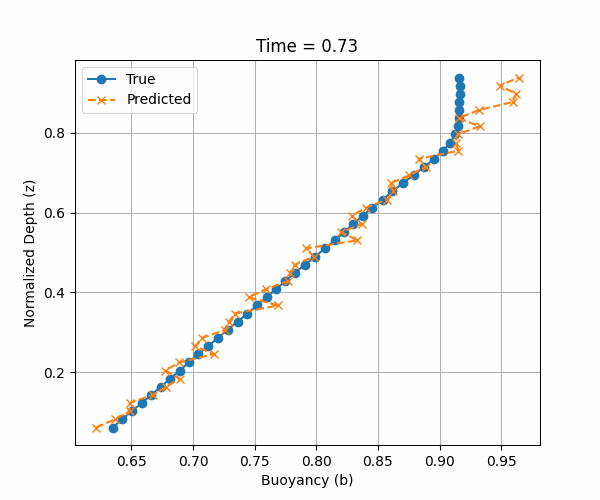

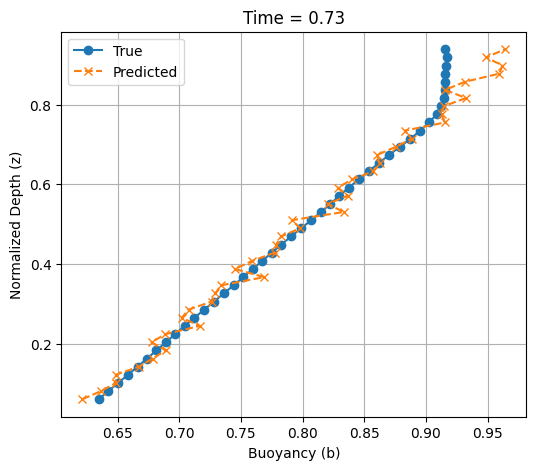

In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image, display

# ---- Step 1: Model Evaluation ----
model.eval()
with torch.no_grad():
    Y_pred_test = model(X_test).cpu().numpy()  # shape: (num_test_samples, 50)

# ---- Step 2: Prepare Trimmed Data for Animation ----
trim_idx_start = 3
trim_idx_end = -3

z_trimmed = depth_vals_normalized[trim_idx_start:trim_idx_end]  # shape: (44,)

b_true_trimmed_list = []
b_pred_trimmed_list = []
times_list = []

Y_test_np = Y_test.cpu().numpy()

for i in range(len(X_test_np)):
    b_true_trim = Y_test_np[i][trim_idx_start:trim_idx_end]
    b_pred_trim = Y_pred_test[i][trim_idx_start:trim_idx_end]
    time_val = X_test_np[i, 0]

    b_true_trimmed_list.append(b_true_trim)
    b_pred_trimmed_list.append(b_pred_trim)
    times_list.append(time_val)

# ---- Step 3: Create Animation ----
fig, ax = plt.subplots(figsize=(6, 5))

def update(frame):
    ax.clear()
    ax.plot(b_true_trimmed_list[frame], z_trimmed, label='True', marker='o')
    ax.plot(b_pred_trimmed_list[frame], z_trimmed, label='Predicted', linestyle='--', marker='x')
    ax.set_xlabel('Buoyancy (b)')
    ax.set_ylabel('Normalized Depth (z)')
    ax.set_title(f'Time = {times_list[frame]:.2f}')
    ax.legend()
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(times_list), blit=False, interval=500)

ani.save('PINN_b_profile_vs_true.gif', writer='pillow', fps=2)
display(Image(filename='PINN_b_profile_vs_true.gif'))
